In [3]:
import sys
sys.path.append('..')
import os
import shutil
import numpy as np
from tqdm import tqdm
from tqdm.contrib.concurrent import process_map
import matplotlib.pyplot as plt
import PIL
from PIL import Image
import random
import seaborn as sns
import pandas as pd
import pickle

from multiprocess import Pool
from program.helper import *
from program.mlp_optimization import *
from program.utility import *

import torch
from torchvision.datasets import ImageFolder
from torchvision.transforms import Compose, Resize, CenterCrop, ToTensor, Normalize
from torch.utils.data import DataLoader
from torchvision.transforms.functional import to_pil_image
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim

from sklearn.metrics import confusion_matrix
from sklearn.metrics import accuracy_score, precision_score
from sklearn.model_selection import KFold

In [4]:
with open('../program/label_translator.pkl', 'rb') as pkl_file:
    label_translator = pickle.load(pkl_file)

## Pre-Processing

In [5]:
# Define a Composal of image transformation used for image load
transform_images = Compose([Resize((227, 227)), 
                            ToTensor(),
                            Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])])

In [9]:
train_data = ImageFolder("../data/train", transform=transform_images)
test_data = ImageFolder("../data/test", transform=transform_images)

In [10]:
dataloader_train = DataLoader(train_data, batch_size=150, shuffle=True, 
                              num_workers=24, pin_memory=True)
dataloader_test = DataLoader(test_data, batch_size=150, shuffle=True, 
                             num_workers=24, pin_memory=True)

# S4: Anwendung Regularisierung

Anwendung von Dropout

In [11]:
from networks import DropOutNetwork, FlatAlexNetOpt

In [16]:
# Calculate for dropout
losses, metrics = {}, {}
for p in [0, .1, .25, .5]:
    print(20*'=', f'Calculation for p = {p}', 20*'=')
    drop_out_model = DropOutNetwork(n_classes=28, p_drop_out=p)
    criterion = nn.CrossEntropyLoss()
    optimizer = optim.SGD(drop_out_model.parameters(),  lr=.01, momentum=.95)
    dtype = torch.float32
    drop_out_model, drop_loss = train_network(model=drop_out_model, criterion=criterion, 
                                              optimizer=optimizer, n_epochs=50, 
                                              dataloader_train=dataloader_train)
    drop_out_metrics = calculate_metrics(model=drop_out_model, dl_train=dataloader_train, 
                                         dl_test=dataloader_test)
    losses['DropOut_'+str(p)] = drop_loss
    metrics['DropOut_'+str(p)] = drop_out_metrics

==================== Calculation for p = 0 ====================


Epoch: 50/50 // Running Loss: 13.25 // Accuracy: 0.653 : 100%|██████████| 8500/8500 [16:11<00:00,  8.75it/s]  
Calculate Acc. on Test Data: 100%|██████████| 19/19 [00:03<00:00,  5.63it/s]


==================== Calculation for p = 0.1 ====================


Epoch: 50/50 // Running Loss: 13.188 // Accuracy: 0.622 : 100%|██████████| 8500/8500 [16:13<00:00,  8.73it/s] 
Calculate Acc. on Test Data: 100%|██████████| 19/19 [00:03<00:00,  5.41it/s]


==================== Calculation for p = 0.25 ====================


Epoch: 50/50 // Running Loss: 31.087 // Accuracy: 0.573 : 100%|██████████| 8500/8500 [16:16<00:00,  8.70it/s]  
Calculate Acc. on Test Data: 100%|██████████| 19/19 [00:03<00:00,  5.51it/s]


==================== Calculation for p = 0.5 ====================


Epoch: 50/50 // Running Loss: 120.997 // Accuracy: 0.442 : 100%|██████████| 8500/8500 [16:15<00:00,  8.72it/s]
Calculate Acc. on Test Data: 100%|██████████| 19/19 [00:03<00:00,  5.76it/s]


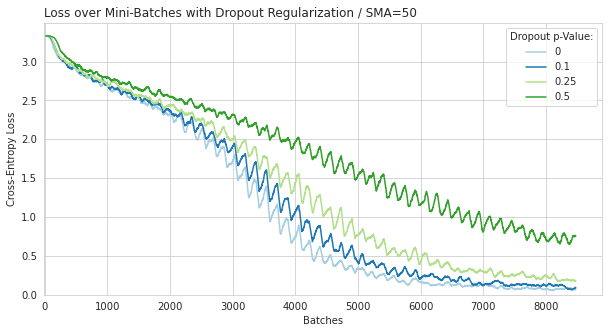

In [19]:
sma = 50
tmp = pd.DataFrame.from_dict(losses)
tmp.columns = [col.split('_')[-1] for col in tmp.columns]
tmp = tmp.reset_index()

for col in tmp.columns:
    tmp[col] = tmp[col].rolling(sma).mean()
tmp = tmp.melt(id_vars='index')

fig = plt.subplots(figsize=(10, 5))
sns.set_style('whitegrid')
sns.set_palette('Paired')
p = sns.lineplot(data=tmp, x='index', y='value', hue='variable')
p.set_title(f'Loss over Mini-Batches with Dropout Regularization / SMA={sma}', loc='left')
p.set_xlabel('Batches')
p.set_ylabel('Cross-Entropy Loss')
plt.legend(title='Dropout p-Value:')
p.set_xlim(left=-5)
p.set_ylim(bottom=0)
plt.savefig('S4_dropout_regularization')
plt.show()

In [20]:
tmp = pd.DataFrame.from_dict(metrics).T
tmp = pd.concat([tmp['accuracy'].explode(), tmp['precision'].explode()], axis=1)
tmp['set'] = ['Train' if i %2 == 0 else 'Test' for i in range(tmp.shape[0])]
tmp['dropout'] = [idx.split('_')[-1] for idx in tmp.index]
tmp = tmp.reset_index(drop=True)
tmp

,accuracy,precision,set,dropout
0,0.982407,0.982621,Train,0
1,0.218188,0.224599,Test,0
2,0.985634,0.985901,Train,0.1
3,0.217483,0.206567,Test,0.1
4,0.98776,0.987809,Train,0.25
5,0.219598,0.223577,Test,0.25
6,0.935611,0.938263,Train,0.5
7,0.213253,0.203134,Test,0.5


In [35]:
tmp_ = tmp.melt(id_vars=['set', 'dropout'])
tmp_['metric'] = tmp_['set'] + '_' + tmp_['variable']
tmp_

,set,dropout,variable,value,metric
0,Train,0,accuracy,0.982407,Train_accuracy
1,Test,0,accuracy,0.218188,Test_accuracy
2,Train,0.1,accuracy,0.985634,Train_accuracy
3,Test,0.1,accuracy,0.217483,Test_accuracy
4,Train,0.25,accuracy,0.98776,Train_accuracy
5,Test,0.25,accuracy,0.219598,Test_accuracy
6,Train,0.5,accuracy,0.935611,Train_accuracy
7,Test,0.5,accuracy,0.213253,Test_accuracy
8,Train,0,precision,0.982621,Train_precision
9,Test,0,precision,0.224599,Test_precision


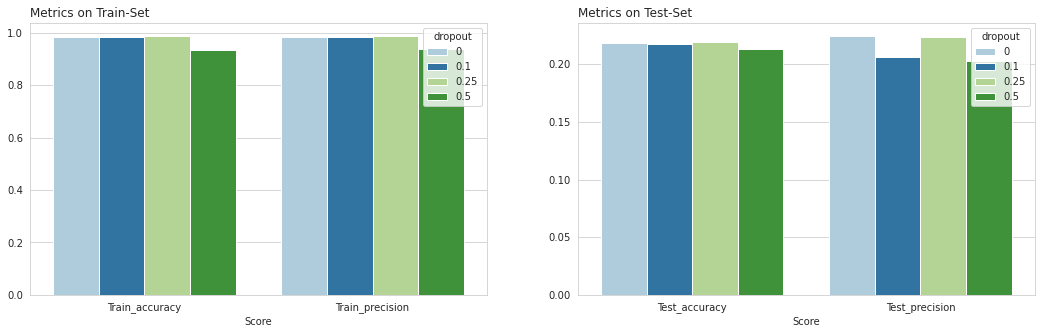

In [49]:
fig = plt.subplots(figsize=(18, 5))

sns.set_palette('Paired', 4)

plt.subplot(1,2,1)
train_tmp = tmp_[tmp_['set'] == 'Train']
p = sns.barplot(data=train_tmp, x='metric', y='value', hue='dropout')
p.set_title('Metrics on Train-Set', loc='left')
p.set_xlabel('Score')
p.set_ylabel('')

plt.subplot(1,2,2)
test_tmp = tmp_[tmp_['set'] == 'Test']
p = sns.barplot(data=test_tmp, x='metric', y='value', hue='dropout')
p.set_title('Metrics on Test-Set', loc='left')
p.set_xlabel('Score')
p.set_ylabel('')

plt.show()